In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os
from PIL import Image
import random
import cv2

### Train data

In [2]:
# Train.csv
train_csv_path = os.getcwd() + "\dataset\Train.csv"
train_df = pd.read_csv(train_csv_path, usecols=['ClassId', 'Path', 'Width', 'Height'])
train_df.head()

,Width,Height,ClassId,Path
0,27,26,20,Train/20/00020_00000_00000.png
1,28,27,20,Train/20/00020_00000_00001.png
2,29,26,20,Train/20/00020_00000_00002.png
3,28,27,20,Train/20/00020_00000_00003.png
4,28,26,20,Train/20/00020_00000_00004.png


In [3]:
# 计算图像的面积
train_df['Area'] = train_df['Width'] * train_df['Height']

In [4]:
train_df.head()

,Width,Height,ClassId,Path,Area
0,27,26,20,Train/20/00020_00000_00000.png,702
1,28,27,20,Train/20/00020_00000_00001.png,756
2,29,26,20,Train/20/00020_00000_00002.png,754
3,28,27,20,Train/20/00020_00000_00003.png,756
4,28,26,20,Train/20/00020_00000_00004.png,728


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39209 entries, 0 to 39208
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Width    39209 non-null  int64 
 1   Height   39209 non-null  int64 
 2   ClassId  39209 non-null  int64 
 3   Path     39209 non-null  object
 4   Area     39209 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 1.5+ MB


In [6]:
# Label Overview (from Kaggle)
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

In [7]:
class_distribution = train_df['ClassId'].value_counts()
class_distribution = class_distribution.rename(index=classes).reset_index()
class_distribution = class_distribution.rename(columns={'index': 'Classes', 'ClassId': 'Count'})
class_distribution

,Classes,Count
0,Speed limit (50km/h),2250
1,Speed limit (30km/h),2220
2,Yield,2160
3,Priority road,2100
4,Keep right,2070
5,No passing veh over 3.5 tons,2010
6,Speed limit (70km/h),1980
7,Speed limit (80km/h),1860
8,Road work,1500
9,No passing,1470


<Figure size 1500x800 with 0 Axes>

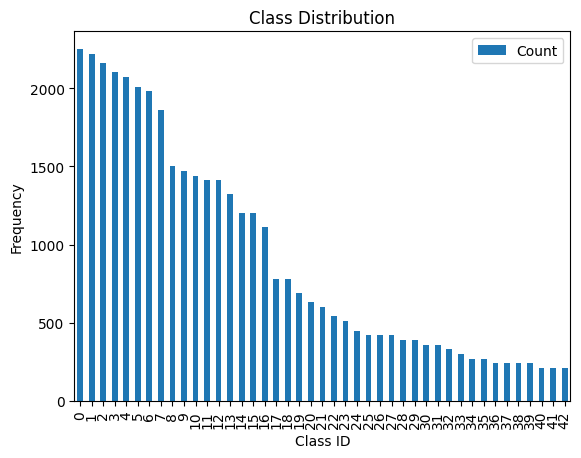

In [13]:
# Visualizing the class distribution
plt.figure(figsize=(15, 8))
class_distribution_sorted = class_distribution.sort_index()  # 对类别分布的索引进行排序
class_distribution_sorted.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class ID')
plt.ylabel('Frequency')
plt.show()

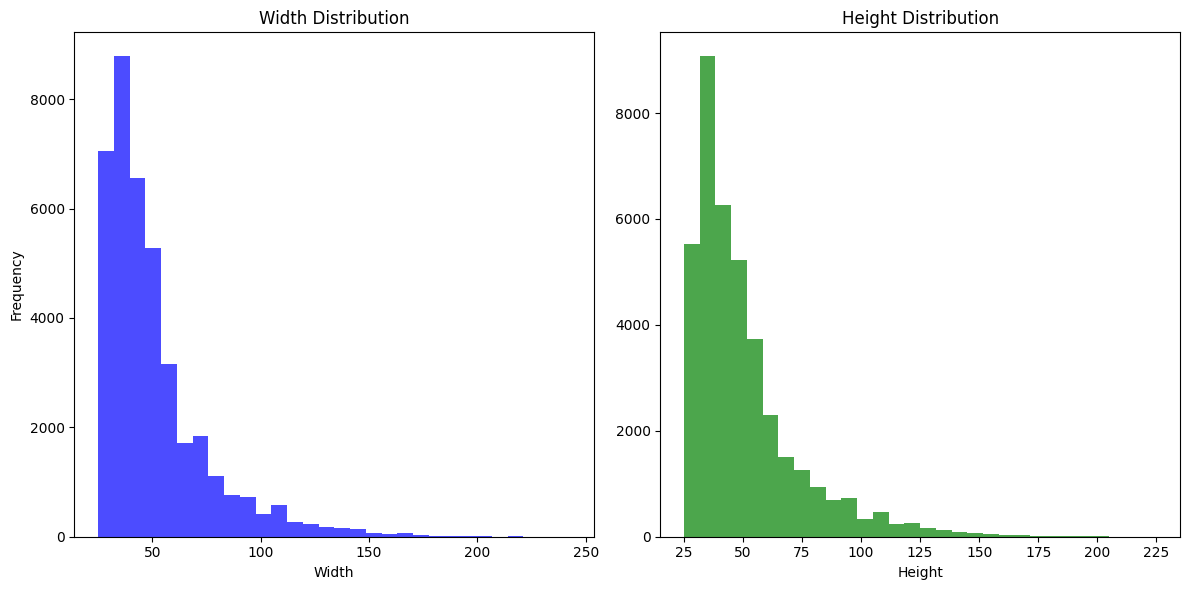

In [9]:
# Analyzing image size distribution
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(train_df['Width'], bins=30, color='blue', alpha=0.7)
plt.title('Width Distribution')
plt.xlabel('Width')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(train_df['Height'], bins=30, color='green', alpha=0.7)
plt.title('Height Distribution')
plt.xlabel('Height')

plt.tight_layout()  # 调整子图的布局
plt.show()

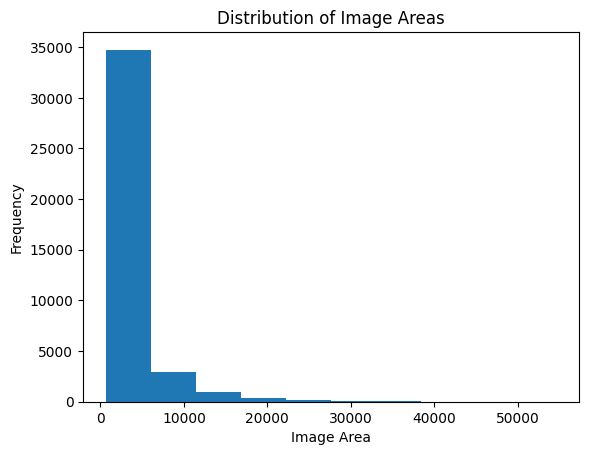

In [10]:
# 绘制面积的直方图
plt.hist(train_df['Area'], bins=10)
plt.xlabel('Image Area')
plt.ylabel('Frequency')
plt.title('Distribution of Image Areas')
plt.show()

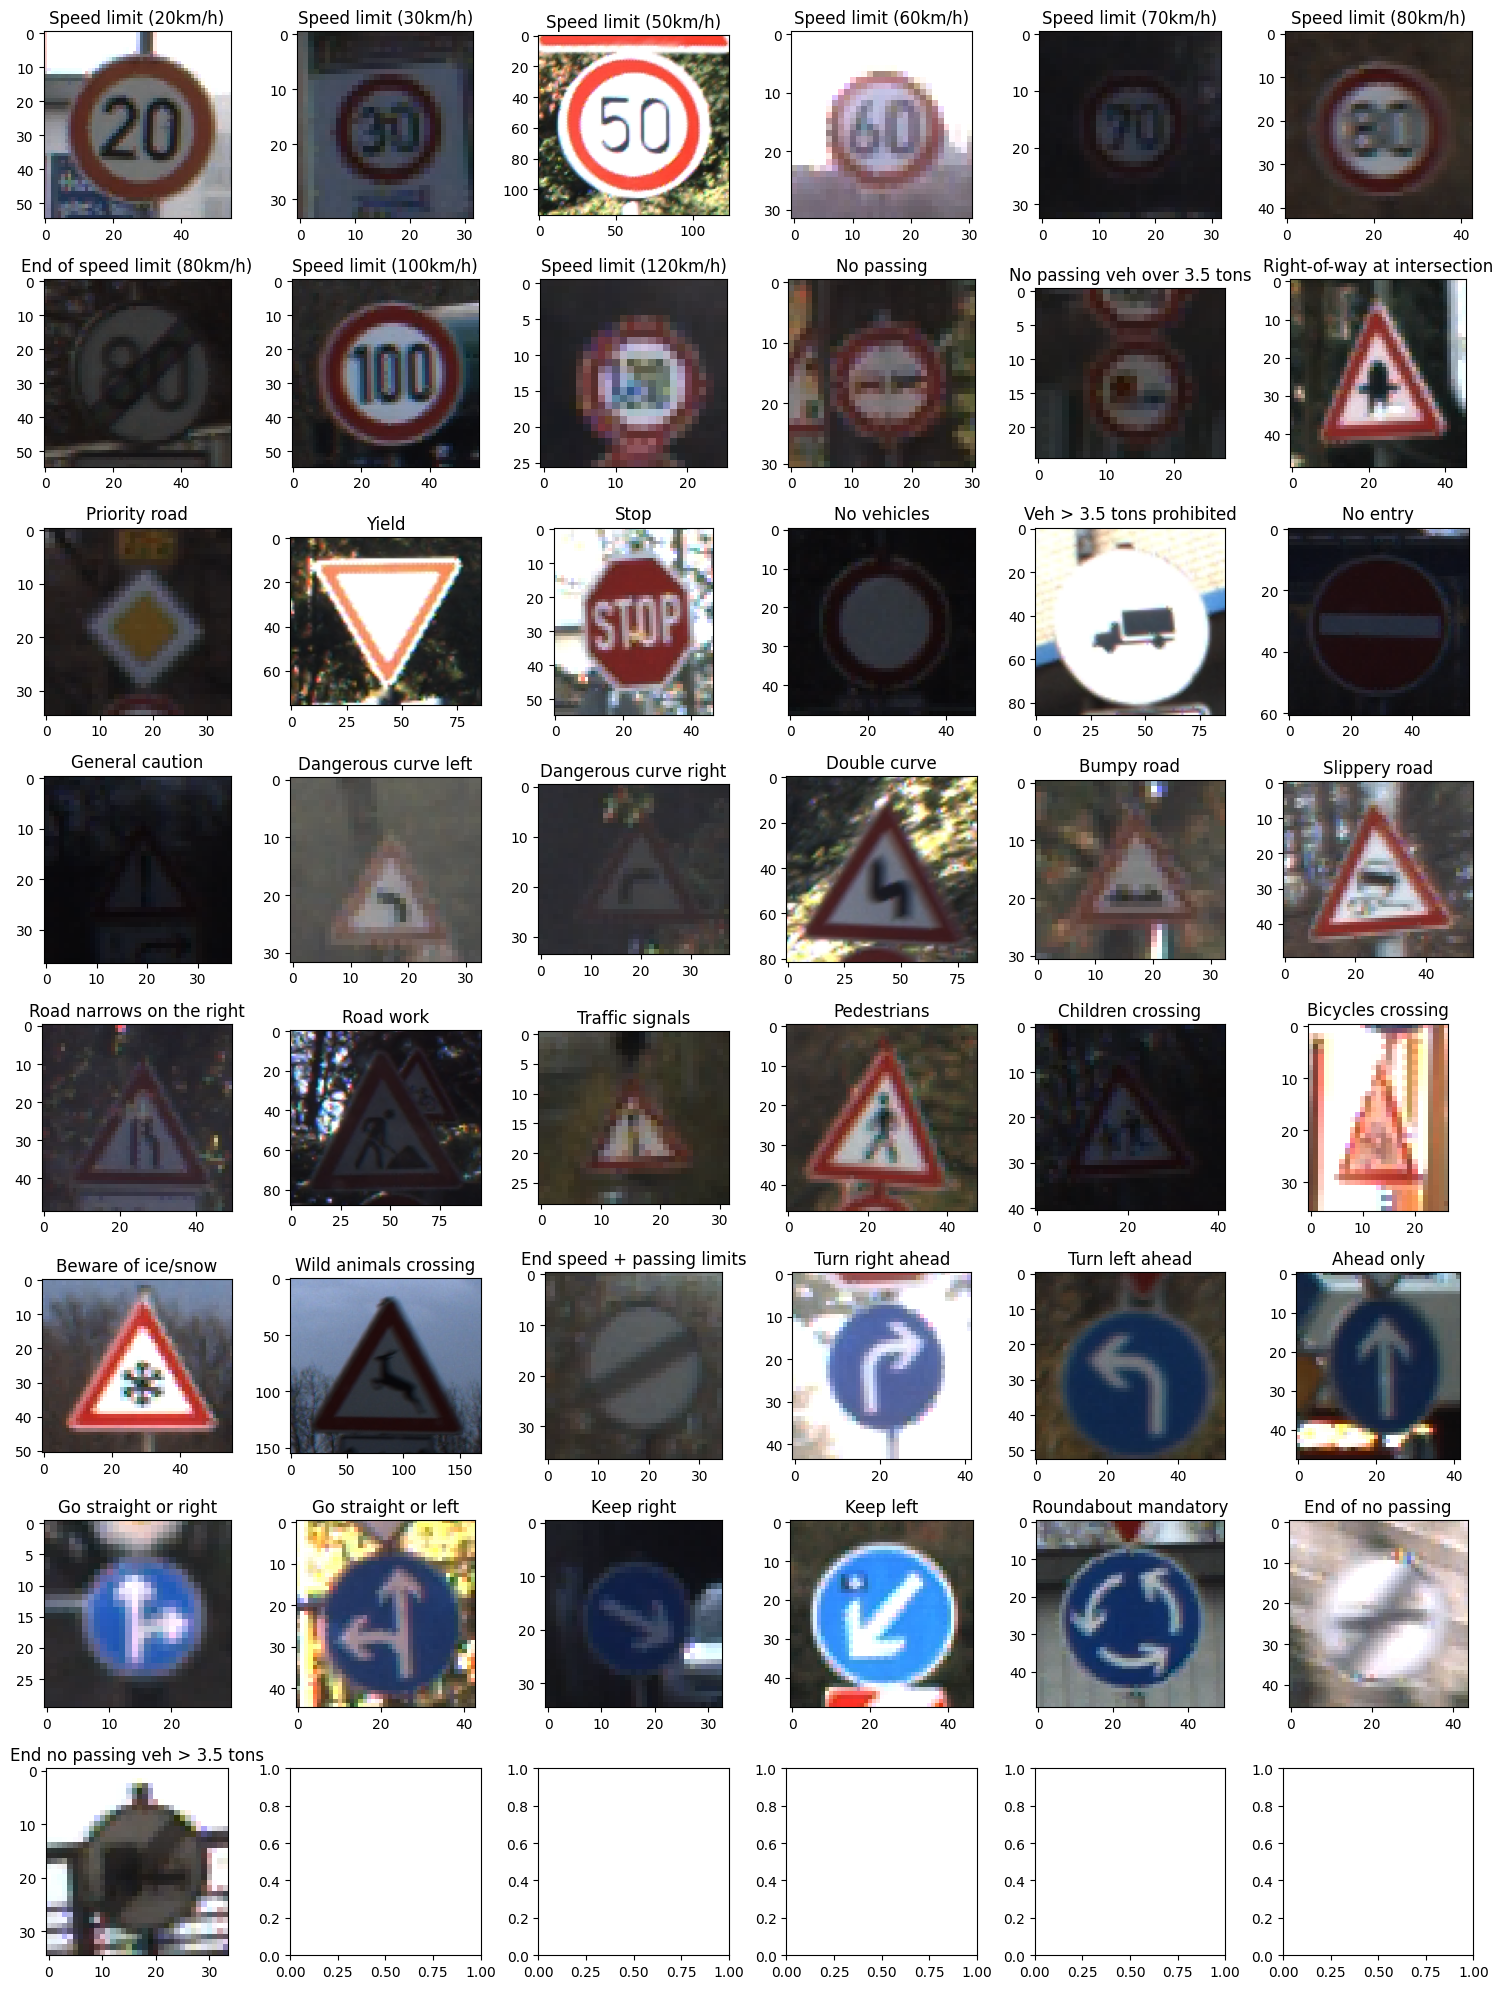

In [11]:
# 将数据集按照类别进行分组
grouped = train_df.groupby('ClassId')

# 创建子图布局，设置6列
fig, axes = plt.subplots(nrows=8, ncols=6, figsize=(15, 20))

# 循环遍历每个类别
for i, (class_id, group) in enumerate(grouped):
    # 随机选择一张图片
    sample = group.sample(1)
    image_path = os.getcwd()+"/dataset/" + sample['Path'].values[0]

    # 加载图片
    image = plt.imread(image_path)

    # 在对应的子图中显示图片
    axes.flat[i].imshow(image)
    axes.flat[i].set_title(classes[class_id])

# 调整子图之间的间距和布局
plt.tight_layout()

# 显示图形
plt.show()